In [84]:
# import libraries
import polars as pl
import numpy as np
import urllib.request
import os
from pathlib import Path
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC

In [85]:
# load CSV
notebook_dir = Path.cwd()
file_path = notebook_dir.parent / "data" / "external" / "FPA_FOD_Plus.csv"

df = pl.read_csv(file_path, infer_schema_length=10000, ignore_errors=True)

# convert DISCOVERY_DATE to datetime
df = df.with_columns(
    pl.col("DISCOVERY_DATE").str.strptime(pl.Date, "%Y-%m-%d").alias("DISCOVERY_DATE")
)

print(df.select("DISCOVERY_DATE").head())
print(f"The number of columns in the dataset: {df.shape[1]}")
print(f"The number of rows in the dataset: {df.shape[0]}")


shape: (5, 1)
┌────────────────┐
│ DISCOVERY_DATE │
│ ---            │
│ date           │
╞════════════════╡
│ 2007-01-01     │
│ 2007-01-01     │
│ 2007-01-01     │
│ 2007-01-01     │
│ 2007-01-01     │
└────────────────┘
The number of columns in the dataset: 308
The number of rows in the dataset: 2302521


In [86]:
df_init = df.to_pandas()
# 1. how many columns does the dataset contain?
print(f"The number of columns in the dataset: {df_init.shape[1]}")

# 2. how many rows are there in the dataset?
print(f"The number of rows in the dataset: {df_init.shape[0]}")


The number of columns in the dataset: 308
The number of rows in the dataset: 2302521


In [87]:
# drop columns that have the number of missing values greater than 80%
cutoff_missing_values = df_init.shape[0]*0.8
missing_vals = df_init.isna().sum().sort_values(ascending=False)
cols_missing_gt80pct = list(missing_vals[missing_vals > cutoff_missing_values].index)
df = df_init.drop(columns=cols_missing_gt80pct)

In [88]:
# 1. how many columns does the dataset contain?
print(f"The number of columns in the dataset: {df.shape[1]}")

# 2. how many rows are there in the dataset?
print(f"The number of rows in the dataset: {df.shape[0]}")

# 3. what are the column names?
print(f"Column names int the dataset: {list(df.columns)}")

The number of columns in the dataset: 284
The number of rows in the dataset: 2302521
Column names int the dataset: ['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'LatLong_State', 'LatLong_County', 'NPL', 'Mang_Type', 'Mang_Name', 'Des_Tp', 'GAP_Sts', 'GAP_Prity', 'EVH', 'EVT', 'EVH_1km', 'EVT_1km', 'EVC', 'EVC_1km', 'NAME', 'MOD_NDVI_12m', 'MOD_EVI_12m', 'Land_Cover', 'Land_Cover_1km', 'rpms', 'rpms_1km', 'Population', 'Popo_1km', 'GACCAbbrev', 'GACC_PL', 'GACC_New fire', 'GACC_Type 1 IMTs', 'GACC_Type 2 IMTs', 'GACC_

#### GACC_New LF GACC_New LF are the two missing that shanti/leo have

In [89]:
print("Data types:")
print(df[['FIRE_SIZE_CLASS', 'FIRE_SIZE']].dtypes)

# dscriptive statistics for FIRE_SIZE
print("\nDescriptive statistics for FIRE_SIZE:")
print(df['FIRE_SIZE'].describe())

# counts per FIRE_SIZE_CLASS using value_counts()
print("\nCounts per FIRE_SIZE_CLASS:")
print(df['FIRE_SIZE_CLASS'].value_counts(sort=True))

# missing values
print("\nMissing values summary:")

missing_summary = pd.DataFrame({
    'FIRE_SIZE_CLASS_missing': [df['FIRE_SIZE_CLASS'].isna().sum()],
    'FIRE_SIZE_missing': [df['FIRE_SIZE'].isna().sum()]
})

print(missing_summary.T) 

# percentiles
print("\nFIRE_SIZE percentiles:")

quantiles = [0.25, 0.5, 0.75, 0.95, 0.99]
percentiles = df['FIRE_SIZE'].quantile(quantiles)

# rename the index for clarity
percentiles.index = ['25%', '50% (median)', '75%', '95%', '99%']
print(percentiles.to_frame().T)


Data types:


FIRE_SIZE_CLASS     object
FIRE_SIZE          float64
dtype: object

Descriptive statistics for FIRE_SIZE:
count    2.302521e+06
mean     7.817802e+01
std      2.631077e+03
min      1.000000e-05
25%      1.000000e-01
50%      8.000000e-01
75%      3.000000e+00
max      6.627000e+05
Name: FIRE_SIZE, dtype: float64

Counts per FIRE_SIZE_CLASS:
FIRE_SIZE_CLASS
B    1103730
A     876238
C     256879
D      34003
E      17193
F       9694
G       4784
Name: count, dtype: int64

Missing values summary:
                         0
FIRE_SIZE_CLASS_missing  0
FIRE_SIZE_missing        0

FIRE_SIZE percentiles:
           25%  50% (median)  75%   95%      99%
FIRE_SIZE  0.1           0.8  3.0  45.0  478.048


/var/folders/3d/thk4g7jj4d52ms21t3_17w_h0000gn/T/ipykernel_5163/42213225.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


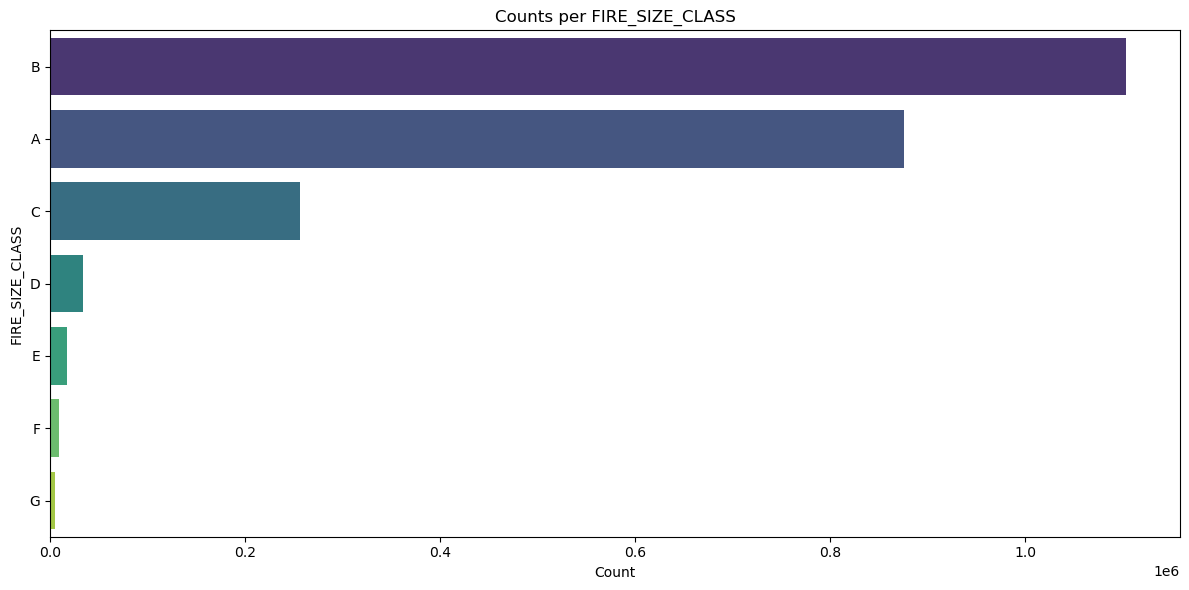

/var/folders/3d/thk4g7jj4d52ms21t3_17w_h0000gn/T/ipykernel_5163/42213225.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


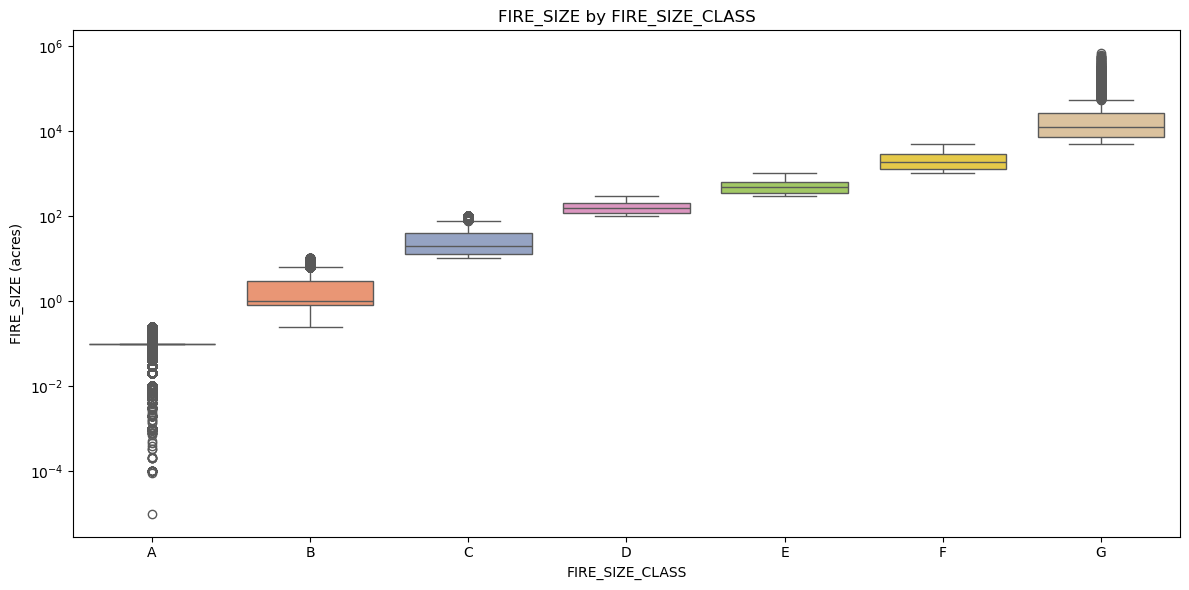

In [90]:
# countplot for FIRE_SIZE_CLASS (categorical)
plt.figure(figsize=(12,6))
sns.countplot(
    data=df,
    y='FIRE_SIZE_CLASS',
    order=df['FIRE_SIZE_CLASS'].value_counts().index,
    palette='viridis'
)
plt.title('Counts per FIRE_SIZE_CLASS')
plt.xlabel('Count')
plt.ylabel('FIRE_SIZE_CLASS')
plt.tight_layout()
plt.show()

# boxplot of FIRE_SIZE by FIRE_SIZE_CLASS
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df,
    x='FIRE_SIZE_CLASS',
    y='FIRE_SIZE',
    palette='Set2'
)
plt.title('FIRE_SIZE by FIRE_SIZE_CLASS')
plt.xlabel('FIRE_SIZE_CLASS')
plt.ylabel('FIRE_SIZE (acres)')
plt.yscale('log')  # optional
plt.tight_layout()
plt.show()

In [91]:
# binning approach 4 (from Nedim's code)
bins_04 = [0, 100, 4999, 29000, df.FIRE_SIZE.max()] 
fire_cats_04 = pd.cut(df.FIRE_SIZE, bins_04)
print(f"{fire_cats_04.value_counts()}")
print(f"\n{fire_cats_04.value_counts(normalize=True)}")
group_names = ['small', 'medium', 'large', 'very large']

df['FIRE_SIZE_LABEL'] = pd.cut(df.FIRE_SIZE, bins_04, labels=group_names)

FIRE_SIZE
(0.0, 100.0]           2241807
(100.0, 4999.0]          55930
(4999.0, 29000.0]         3682
(29000.0, 662700.0]       1102
Name: count, dtype: int64

FIRE_SIZE
(0.0, 100.0]           0.973632
(100.0, 4999.0]        0.024291
(4999.0, 29000.0]      0.001599
(29000.0, 662700.0]    0.000479
Name: proportion, dtype: float64


In [92]:
df.FIRE_SIZE_LABEL.value_counts()

FIRE_SIZE_LABEL
small         2241807
medium          55930
large            3682
very large       1102
Name: count, dtype: int64

## Data Pre-Processing

In [93]:
# recode fire_size_label  from string to numeric
firelabel_mapping = {
    'small': 0,
    'medium': 1,
    'large': 2,
    'very large': 3
}
print(f"{firelabel_mapping=}")

df['FIRE_SIZE_LABEL'] = df['FIRE_SIZE_LABEL'].map(firelabel_mapping) 

print(f"Column names in the dataset: {list(df.columns)}")

firelabel_mapping={'small': 0, 'medium': 1, 'large': 2, 'very large': 3}
Column names in the dataset: ['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'LatLong_State', 'LatLong_County', 'NPL', 'Mang_Type', 'Mang_Name', 'Des_Tp', 'GAP_Sts', 'GAP_Prity', 'EVH', 'EVT', 'EVH_1km', 'EVT_1km', 'EVC', 'EVC_1km', 'NAME', 'MOD_NDVI_12m', 'MOD_EVI_12m', 'Land_Cover', 'Land_Cover_1km', 'rpms', 'rpms_1km', 'Population', 'Popo_1km', 'GACCAbbrev', 'GACC_PL', 'GACC_New fire', 'GACC_Type 1 IMTs', 'GACC_Type 2 IMTs', 'GACC_NIMO Teams', 

## Feature Engineering

In [94]:
# create a binary variable for East vs. West Coast
# use a central longitude
df['IS_WEST_OF_100'] = np.where(df['LONGITUDE'] < -100, 1, 0)
print("\nNew feature 'IS_WEST_OF_100' created successfully.")
print(df['IS_WEST_OF_100'].value_counts())



New feature 'IS_WEST_OF_100' created successfully.
IS_WEST_OF_100
0    1462142
1     840379
Name: count, dtype: int64


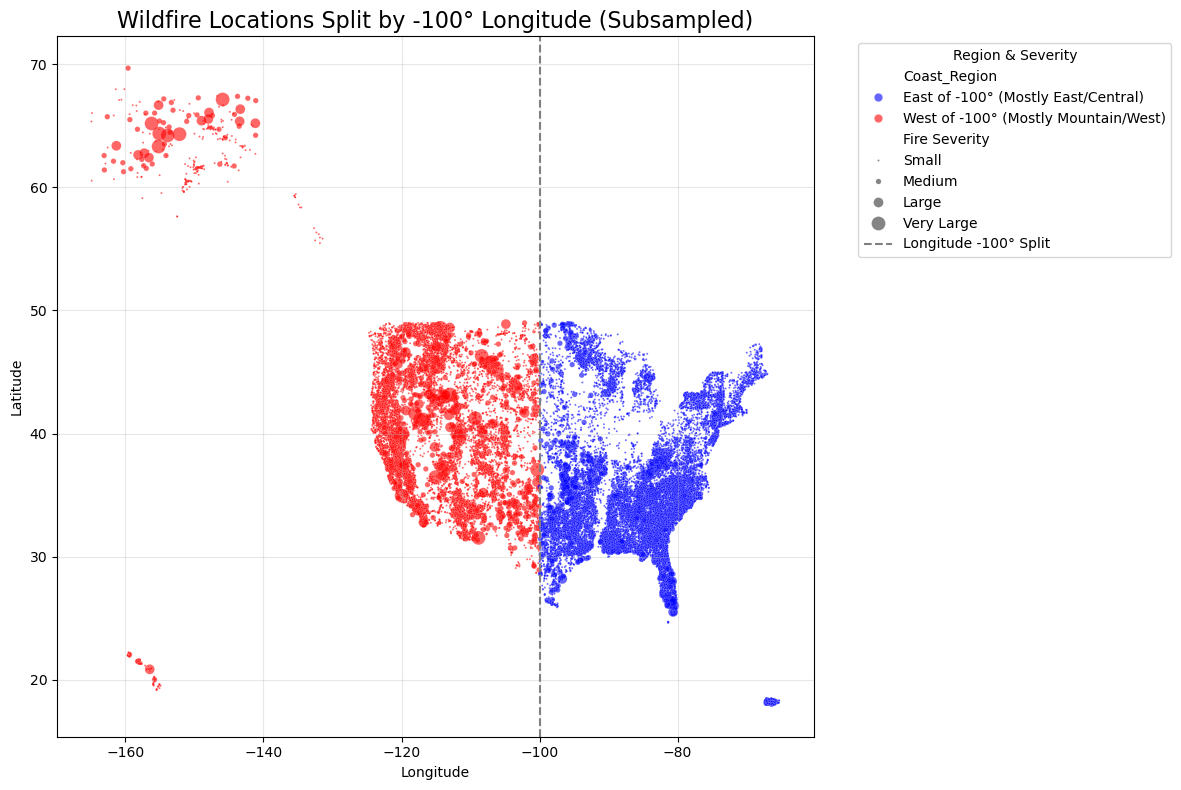

In [95]:
# geo plot (uses subsample)
df_plot = df.sample(n=50000, random_state=42).copy()

# map variables for HUE (color) and SIZE LEGEND (labels)
df_plot['Coast_Region'] = df_plot['IS_WEST_OF_100'].map({1: 'West of -100° (Mostly Mountain/West)', 0: 'East of -100° (Mostly East/Central)'})
df_plot['Fire_Severity_Label'] = df_plot['FIRE_SIZE_LABEL'].map({
    0: 'Small', 
    1: 'Medium', 
    2: 'Large', 
    3: 'Very Large'
})

# use FIRE_SIZE_LABEL (0, 1, 2, 3) directly for the size encoding.
custom_sizes = {0: 2, 1: 15, 2: 50, 3: 100}

severity_order = ['Small', 'Medium', 'Large', 'Very Large']

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_plot,
    x='LONGITUDE', 
    y='LATITUDE',
    hue='Coast_Region',
    # use the NUMERICAL column for size mapping
    size='FIRE_SIZE_LABEL', 
    sizes=custom_sizes, 
    alpha=0.6,
    palette={'West of -100° (Mostly Mountain/West)': 'red', 'East of -100° (Mostly East/Central)': 'blue'},
    legend='full'
)

# draw the boundary line
plt.axvline(x=-100, color='gray', linestyle='--', linewidth=1.5, label='Longitude -100° Split')

h, l = plt.gca().get_legend_handles_labels()

# find the start index of the size legend items
size_legend_start_index = l.index('FIRE_SIZE_LABEL') + 1

# rename the size legend title and labels
l[size_legend_start_index - 1] = 'Fire Severity'
l[size_legend_start_index + 0] = 'Small'
l[size_legend_start_index + 1] = 'Medium'
l[size_legend_start_index + 2] = 'Large'
l[size_legend_start_index + 3] = 'Very Large'


plt.gca().legend(h, l, title='Region & Severity', bbox_to_anchor=(1.05, 1), loc=2)

plt.title('Wildfire Locations Split by -100° Longitude (Subsampled)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [96]:
# The original are no longer needed
df = df.drop(columns=['LATITUDE', 'LONGITUDE'], errors='ignore')
print("Dropped original LATITUDE and LONGITUDE columns.")

Dropped original LATITUDE and LONGITUDE columns.


In [97]:
np.random.seed(207)

val_size = 0.2/(0.2 + 0.6)
df_train_main, df_test = train_test_split(df, test_size= 0.2, random_state=207,
                                           stratify=list(zip(df['FIRE_YEAR'], df['FIRE_SIZE_LABEL'])))
df_train, df_val = train_test_split(df_train_main, test_size=val_size, random_state=207,
                                     stratify=list(zip(df_train_main['FIRE_YEAR'], df_train_main['FIRE_SIZE_LABEL'])))

# print shapes
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")
print(f"Shape of df_test: {df_test.shape}")

Shape of df_train: (1381512, 284)
Shape of df_val: (460504, 284)
Shape of df_test: (460505, 284)


In [98]:
# from FPA FOD data: LATITUDE/LONGITUDE removed, IS_WEST_OF_100 added
trgt_feat_fod = ['FIRE_SIZE_LABEL', 'FIRE_YEAR', 'DISCOVERY_DOY', 'NWCG_CAUSE_CLASSIFICATION', 'IS_WEST_OF_100']

# from GRIDMET: variables surround 5-day window centered on the fire discovery date
feat_gridmet = list(df_train.columns[df_train.columns.str.contains('_5D_') & ~df_train.columns.str.contains('5D_mean') & ~df_train.columns.str.contains('5D_min') & ~df_train.columns.str.contains('5D_max')])

feat_gridmet = [col for col in df_train.columns if '_5D_' in col]
feat_rmgmta = ['SDI']
feat_firestation = ['No_FireStation_20.0km']
feat_gacc = ['GACC_PL']
feat_ghm = ['GHM']
feat_ndvi = ['NDVI-1day']      
feat_npl = ['NPL']
feat_svi = ['EPL_PCI']
feat_rangeland = ['rpms', 'rpms_1km']

In [99]:
# compile selected vars
trgt_feat_selected = trgt_feat_fod + feat_gridmet + feat_rmgmta + feat_firestation + feat_gacc + feat_ghm + feat_ndvi + feat_npl + feat_svi + feat_rangeland
# Drop duplicates just in case
trgt_feat_selected = list(set(trgt_feat_selected))
# select only variables of interest (outcome and features)
df_train = df_train[trgt_feat_selected]
df_val = df_val[trgt_feat_selected]
df_test = df_test[trgt_feat_selected]

# print shapes
print(f"\nShape of df_train after selection: {df_train.shape}")
print(f"Shape of df_val after selection: {df_val.shape}")
print(f"Shape of df_test after selection: {df_test.shape}")


Shape of df_train after selection: (1381512, 45)
Shape of df_val after selection: (460504, 45)
Shape of df_test after selection: (460505, 45)


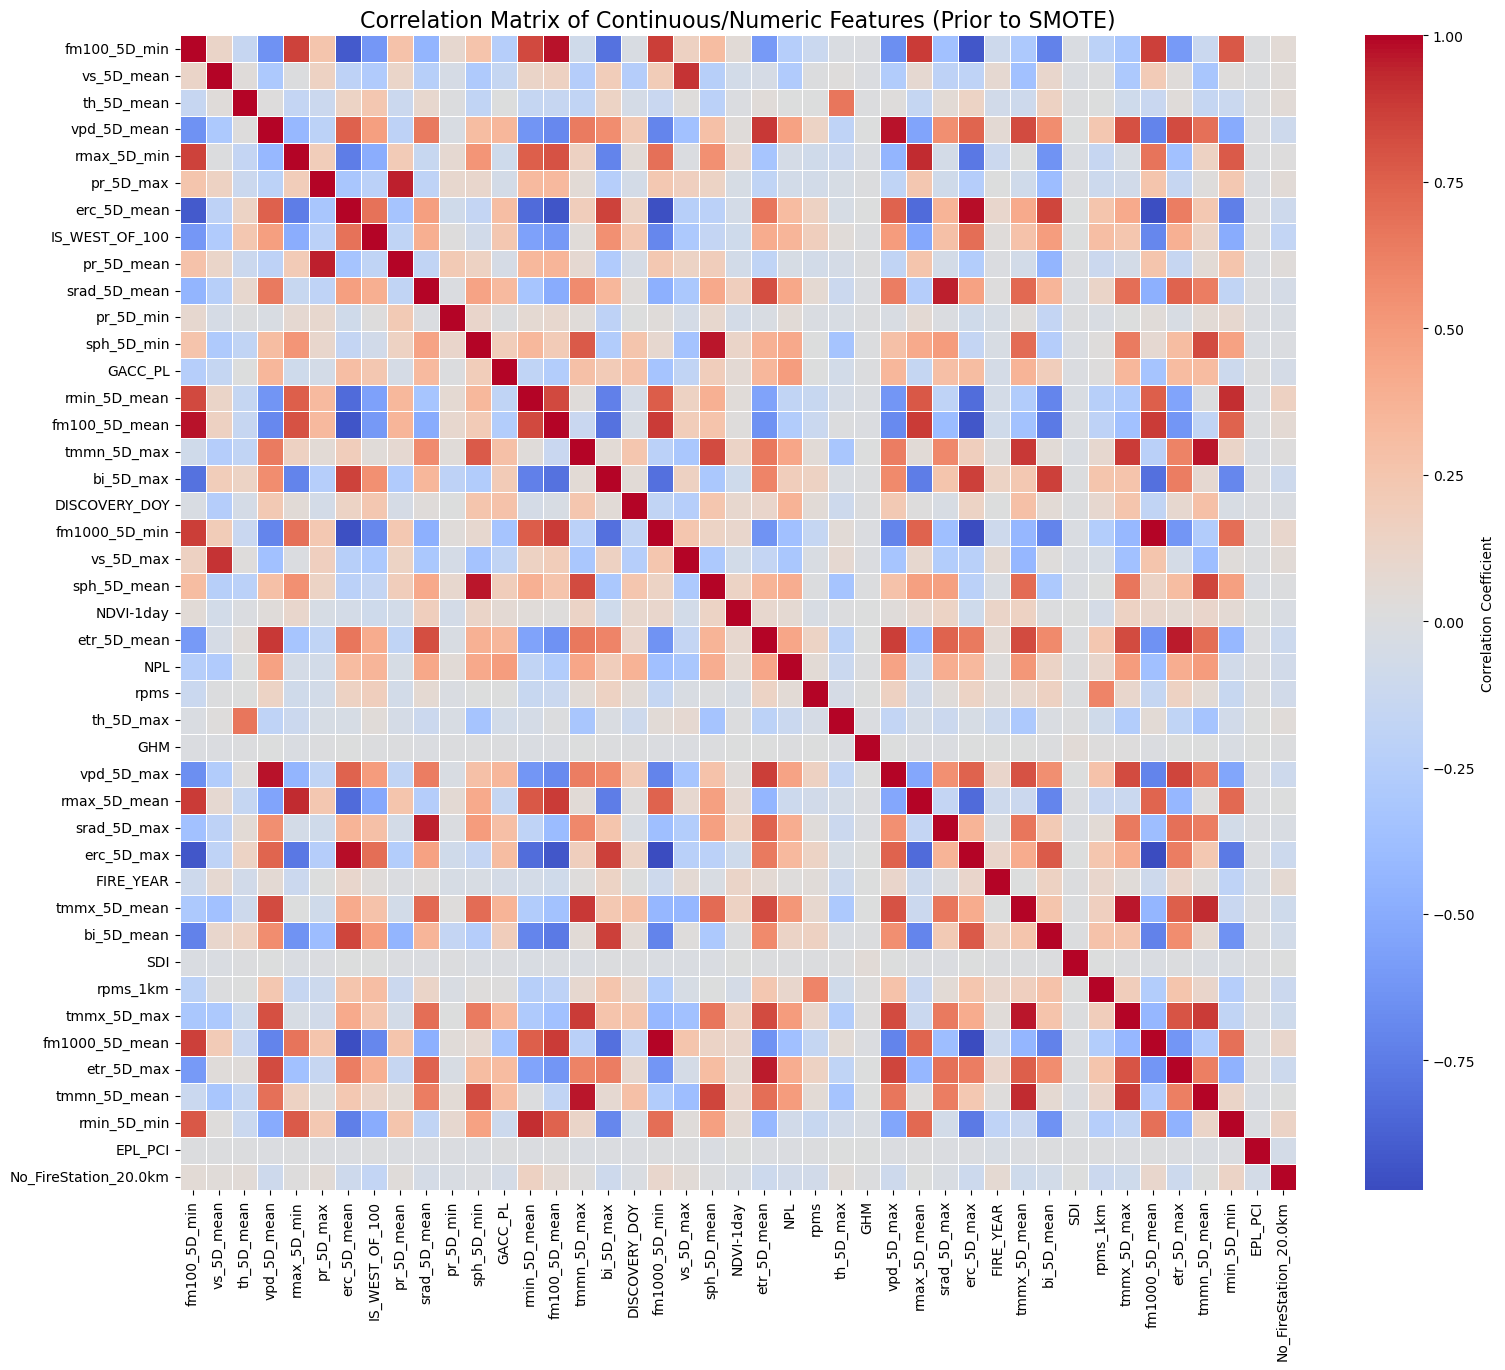

In [100]:
numeric_df = df.select_dtypes(include=np.number)

correlation_matrix = numeric_df_train.corr()

plt.figure(figsize=(18, 15)) 

sns.heatmap(
    correlation_matrix, 
    annot=False, 
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Correlation Matrix of Continuous/Numeric Features (Prior to SMOTE)', fontsize=16)
plt.show()

In [101]:
# check for missing value
df_train.isna().sum().sort_values(ascending=False)

GACC_PL                      710064
EPL_PCI                       58948
NDVI-1day                     45581
th_5D_mean                    28478
fm100_5D_min                  28478
pr_5D_min                     28478
pr_5D_max                     28478
erc_5D_mean                   28478
pr_5D_mean                    28478
sph_5D_min                    28478
vs_5D_mean                    28478
vpd_5D_mean                   28478
rmax_5D_min                   28478
rmin_5D_min                   28478
tmmn_5D_mean                  28478
srad_5D_mean                  28478
fm100_5D_mean                 28478
bi_5D_max                     28478
fm1000_5D_min                 28478
vs_5D_max                     28478
rmin_5D_mean                  28478
etr_5D_mean                   28478
sph_5D_mean                   28478
th_5D_max                     28478
tmmx_5D_mean                  28478
rmax_5D_mean                  28478
srad_5D_max                   28478
vpd_5D_max                  

In [102]:
def impute_with_zero(df):
    """Impute the missing values in selected columns with zero

    Args:
     - df: a data frame

    Return:
    - df: a data frame 
    """

    # vars impute with zero
    cols_impute_zero = ['No_FireStation_20.0km', 'GACC_PL']

    for column in cols_impute_zero:
        df[column] = df[column].fillna(0)
    
    return df

In [103]:
# selected vars: impute missing values with zero
df_train = impute_with_zero(df_train)
df_val = impute_with_zero(df_val)
df_test = impute_with_zero(df_test)

In [104]:
# selected vars: impute with missing values the mean

# replace value of -999.0 (the only value less than 0) in EPL_PCI as missing values
for data in [df_train, df_val, df_test]:
    data['EPL_PCI'] = data['EPL_PCI'].replace(-999, np.nan)

cols_impute_mean = feat_gridmet + ['SDI', 'EPL_PCI', 'NDVI-1day']

imp_x = SimpleImputer(missing_values=np.nan, strategy='mean')
df_train[cols_impute_mean] = imp_x.fit(df_train[cols_impute_mean]).transform(df_train[cols_impute_mean])
df_val[cols_impute_mean] = imp_x.fit(df_train[cols_impute_mean]).transform(df_val[cols_impute_mean])
df_test[cols_impute_mean] = imp_x.fit(df_train[cols_impute_mean]).transform(df_test[cols_impute_mean])

In [105]:
# sanity check for missing value 
df_train.isna().sum().sort_values(ascending=False)

FIRE_SIZE_LABEL              0
fm100_5D_min                 0
vs_5D_mean                   0
th_5D_mean                   0
vpd_5D_mean                  0
rmax_5D_min                  0
pr_5D_max                    0
erc_5D_mean                  0
IS_WEST_OF_100               0
pr_5D_mean                   0
srad_5D_mean                 0
pr_5D_min                    0
sph_5D_min                   0
GACC_PL                      0
rmin_5D_mean                 0
fm100_5D_mean                0
tmmn_5D_max                  0
bi_5D_max                    0
DISCOVERY_DOY                0
fm1000_5D_min                0
vs_5D_max                    0
sph_5D_mean                  0
NDVI-1day                    0
NWCG_CAUSE_CLASSIFICATION    0
etr_5D_mean                  0
NPL                          0
rpms                         0
th_5D_max                    0
GHM                          0
vpd_5D_max                   0
rmax_5D_mean                 0
srad_5D_max                  0
erc_5D_m

In [106]:
nwcg_cause_simplified = {
    'Human' : 'hum',
    'Natural' : 'nat',
    'Missing data/not specified/undetermined' : 'miss-unspec'
    
}

for data in [df_train, df_val, df_test]:
    data['NWCG_CAUSE_CLASSIFICATION'] = data['NWCG_CAUSE_CLASSIFICATION'].map(nwcg_cause_simplified)

In [107]:
# SMOTENC

# define outcome and features before balancing
Y_train = df_train['FIRE_SIZE_LABEL']
Y_val = df_val['FIRE_SIZE_LABEL']
Y_test = df_test['FIRE_SIZE_LABEL']

X_train = df_train.drop(columns=['FIRE_SIZE_LABEL'])
X_val = df_val.drop(columns=['FIRE_SIZE_LABEL'])
X_test = df_test.drop(columns=['FIRE_SIZE_LABEL'])

print(f"\nShape of X_train before SMOTENC: {X_train.shape}")
print(f"Original Class distribution, training data:\n{Y_train.value_counts()}")


# SMOTENC Application
cols_categorical = ['NWCG_CAUSE_CLASSIFICATION', 'GACC_PL', 'IS_WEST_OF_100']

# get the indices of the categorical columns within X_train
cat_feature_indices = [X_train.columns.get_loc(col) for col in cols_categorical]

# apply SMOTENC to the training data only
smote_nc = SMOTENC(categorical_features=cat_feature_indices, random_state=207)
X_train_resampled, Y_train_resampled = smote_nc.fit_resample(X_train, Y_train)

print(f"\nClass distribution after SMOTENC, training data:\n{Y_train_resampled.value_counts()}")
print(f"Shape of X_train_resampled: {X_train_resampled.shape}")


Shape of X_train before SMOTENC: (1381512, 44)
Original Class distribution, training data:
FIRE_SIZE_LABEL
0    1345082
1      33560
2       2210
3        660
Name: count, dtype: int64

Class distribution after SMOTENC, training data:
FIRE_SIZE_LABEL
0    1345082
1    1345082
2    1345082
3    1345082
Name: count, dtype: int64
Shape of X_train_resampled: (5380328, 44)


In [108]:
# One-Hot Encoding

# apply OHE to all three sets
X_train_res_ohe = pd.get_dummies(X_train_resampled, columns=cols_categorical, drop_first=True)
X_val_ohe = pd.get_dummies(X_val, columns=cols_categorical, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, columns=cols_categorical, drop_first=True)

# te-align Validation and Test columns to match the Training set
X_train_ohe_cols = X_train_res_ohe.columns

# align validation set
missing_cols_val = set(X_train_ohe_cols) - set(X_val_ohe.columns)
for c in missing_cols_val: X_val_ohe[c] = 0
X_val_ohe = X_val_ohe[X_train_ohe_cols]

# align test set
missing_cols_test = set(X_train_ohe_cols) - set(X_test_ohe.columns)
for c in missing_cols_test: X_test_ohe[c] = 0
X_test_ohe = X_test_ohe[X_train_ohe_cols]

print(f"Number of features after OHE: {len(X_train_ohe_cols)}")

Number of features after OHE: 49


In [109]:
# Standardization and Concatenation

# recalculate continuous columns *after* OHE
cols_continuous = [col for col in X_train_ohe_cols if col not in X_train_res_ohe.columns.str.contains('|'.join(cols_categorical)).tolist()]
# continuous columns are the ones that were not in cols_categorical
cols_continuous = [col for col in trgt_feat_selected if col not in cols_categorical and col != 'FIRE_SIZE_LABEL']


X_train_res_continuous = X_train_res_ohe[cols_continuous]
X_train_res_onehot = X_train_res_ohe.drop(columns=cols_continuous)
X_val_continuous = X_val_ohe[cols_continuous]
X_val_onehot = X_val_ohe.drop(columns=cols_continuous)
X_test_continuous = X_test_ohe[cols_continuous]
X_test_onehot = X_test_ohe.drop(columns=cols_continuous)

# standardized continuous features
sc_x = StandardScaler()

X_train_res_cont_std = sc_x.fit_transform(X_train_res_continuous)
X_val_cont_std = sc_x.transform(X_val_continuous) # Note: Only transform, do not fit again
X_test_cont_std = sc_x.transform(X_test_continuous) # Note: Only transform, do not fit again

# add one-hot-encoded vars back 
X_train_final = np.concatenate((X_train_res_cont_std, X_train_res_onehot), axis= 1)
X_val_final = np.concatenate((X_val_cont_std, X_val_onehot), axis= 1)
X_test_final = np.concatenate((X_test_cont_std, X_test_onehot), axis= 1)

print("-" * 50)
print(f"Final training set shape after all steps: {X_train_final.shape}")
print(f"Final validation set shape: {X_val_final.shape}")
print(f"Final test set shape: {X_test_final.shape}")

--------------------------------------------------
Final training set shape after all steps: (5380328, 49)
Final validation set shape: (460504, 49)
Final test set shape: (460505, 49)
